In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to Generative Adversarial Networks (GANs)

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture.

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN.



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 893kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.67MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataloader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

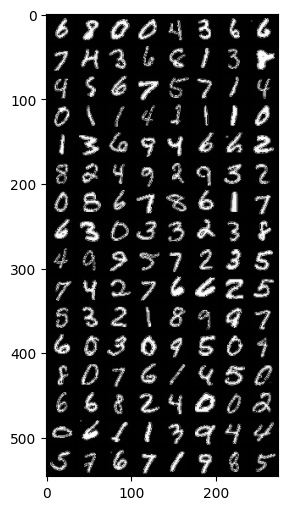

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm
- ReLU

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU,
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        ###################
        return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding),
            nn.Tanh()
        )
        ###################
    else:
        ###################
        return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding),
            nn.BatchNorm2d(channels_out),
            nn.ReLU()
        )
        ###################




class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()

        ###################

        self.model = nn.Sequential(
            get_upscaling_block(nz, ngf*4, kernel=4, stride=1, padding=0),  # (n_batch, ngf*4, 4, 4)
            get_upscaling_block(ngf*4, ngf*2, kernel=4, stride=2, padding=1),  # (n_batch, ngf*2, 8, 8)
            get_upscaling_block(ngf*2, ngf, kernel=4, stride=2, padding=1),  # (n_batch, ngf, 16, 16)
            get_upscaling_block(ngf, nchannels, kernel=4, stride=2, padding=1, last_layer=True)  # (n_batch, 1, 32, 32)
        )

        ###################

    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)


### 2.1.3. Sanity Tests

In [ ]:
nz = 1000
z = torch.randn(batch_size, nz)

In [ ]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)


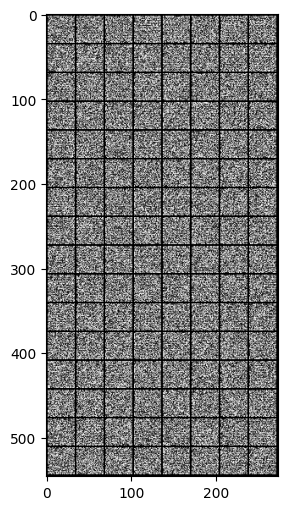

In [ ]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator.

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]`

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):

    if is_last:
        ###################
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel, stride, padding),
            nn.Sigmoid()
        )
        ###################

    elif not use_batch_norm:
        ###################
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel, stride, padding),
            nn.LeakyReLU(negative_slope=0.2)
        )
        ###################

    else:
        ###################
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel, stride, padding),
            nn.BatchNorm2d(channels_out),
            nn.LeakyReLU(negative_slope=0.2)
        )
        ###################




class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()

        ###################

        self.model = nn.Sequential(
            get_downscaling_block(nchannels, ndf, kernel=4, stride=2, padding=1),  # (n_batch, ndf, 16, 16)
            get_downscaling_block(ndf, ndf*2, kernel=4, stride=2, padding=1),  # (n_batch, ndf*2, 8, 8)
            get_downscaling_block(ndf*2, ndf*4, kernel=4, stride=2, padding=1),  # (n_batch, ndf*4, 4, 4)
            get_downscaling_block(ndf*4, 1, kernel=4, stride=1, padding=0, is_last=True)  # (n_batch, 1, 1, 1)
        )

        ###################

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions (n_batch, 1)

### 2.2.3 Sanity Checking

In [ ]:
real_batch, real_labels = next(iter(dataloader))

In [ ]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

# 3. Training

## 3.1 Loss
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [ ]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions.
1. First, we need to continuously sample z from a Gaussian distribution.
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s.

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1)
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
# 定义初始化函数
def weights_init(m):
    # 获取当前层的类名，比如 'Conv2d', 'BatchNorm2d' 等
    classname = m.__class__.__name__

    # 如果当前层是卷积层（包括 Conv2d、ConvTranspose2d 等）
    if classname.find('Conv') != -1:
        # 用均值为 0、标准差为 0.02 的高斯分布初始化权重
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    # 如果当前层是批归一化层（BatchNorm2d）
    elif classname.find('BatchNorm') != -1:
        # 用均值为 1、标准差为 0.02 的高斯分布初始化权重
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        # 将偏置初始化为常数 0
        nn.init.constant_(m.bias.data, 0)


# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training!
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve.
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

it: 0; g_loss: 0.9229776859283447; d_loss: 1.8851016759872437; avg_real_score: 0.3229093551635742; avg_fake_score: 0.4771222472190857: : 0it [00:01, ?it/s]

generated images


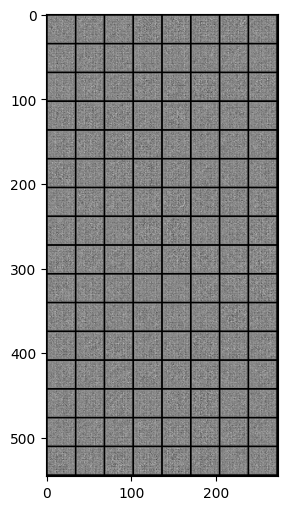

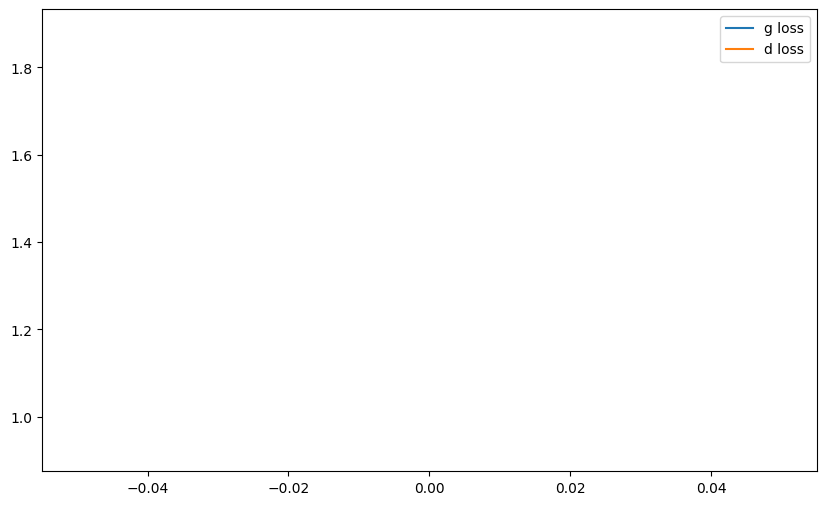

it: 200; g_loss: 2.1201024055480957; d_loss: 0.6140142679214478; avg_real_score: 0.7608469128608704; avg_fake_score: 0.27034878730773926: : 199it [00:13, 17.51it/s]

generated images


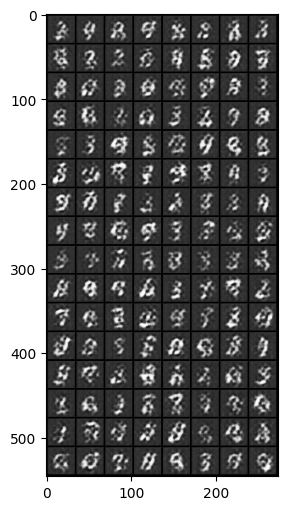

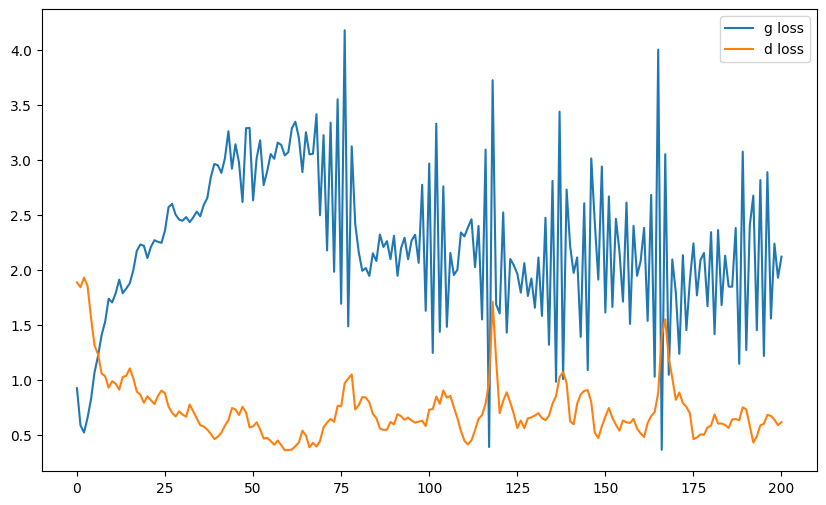

it: 400; g_loss: 2.7129459381103516; d_loss: 1.0943084955215454; avg_real_score: 0.9835066199302673; avg_fake_score: 0.6185978055000305: : 399it [00:26, 16.45it/s]  

generated images


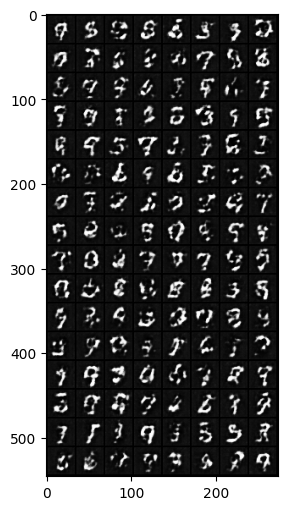

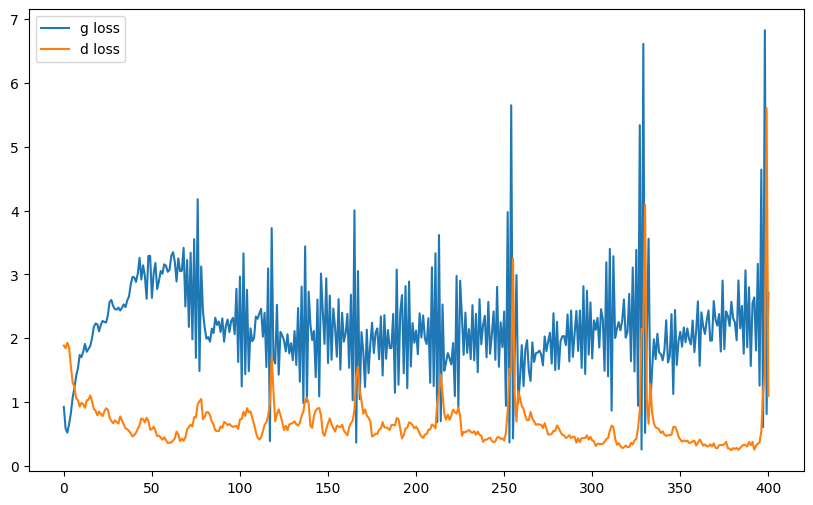

it: 468; g_loss: 2.131781578063965; d_loss: 0.7200188636779785; avg_real_score: 0.8041169047355652; avg_fake_score: 0.3779112994670868: : 469it [00:31, 14.90it/s]
it: 469; g_loss: 0.8273733258247375; d_loss: 0.8221344947814941; avg_real_score: 0.5441283583641052; avg_fake_score: 0.15683580935001373: : 0it [00:00, ?it/s]

generated images


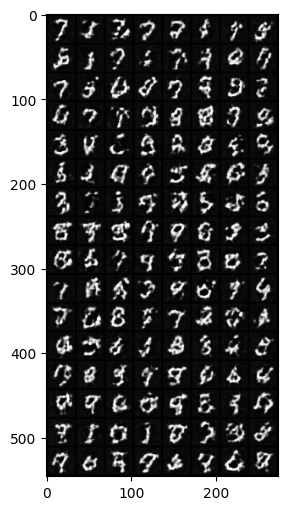

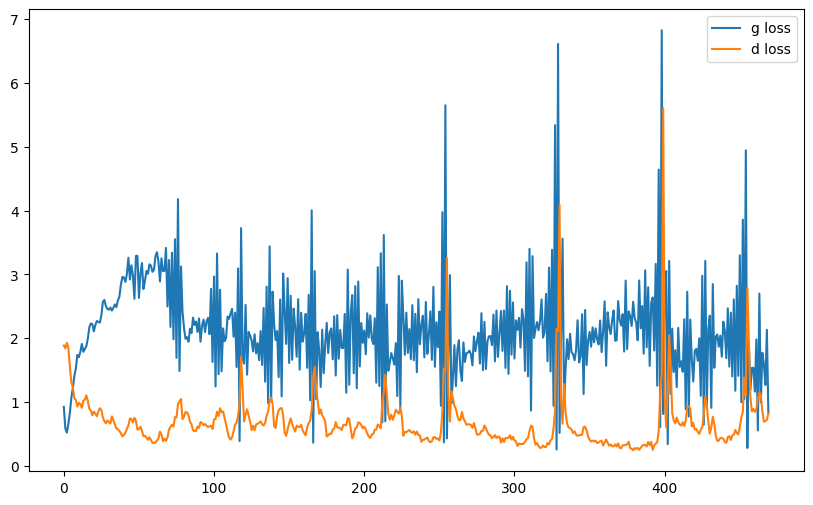

it: 669; g_loss: 2.3754448890686035; d_loss: 0.9294449687004089; avg_real_score: 0.8765054941177368; avg_fake_score: 0.5280212759971619: : 199it [00:13, 16.30it/s] 

generated images


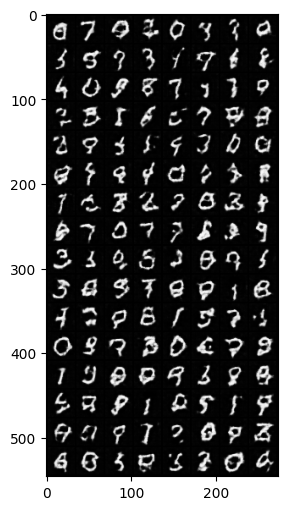

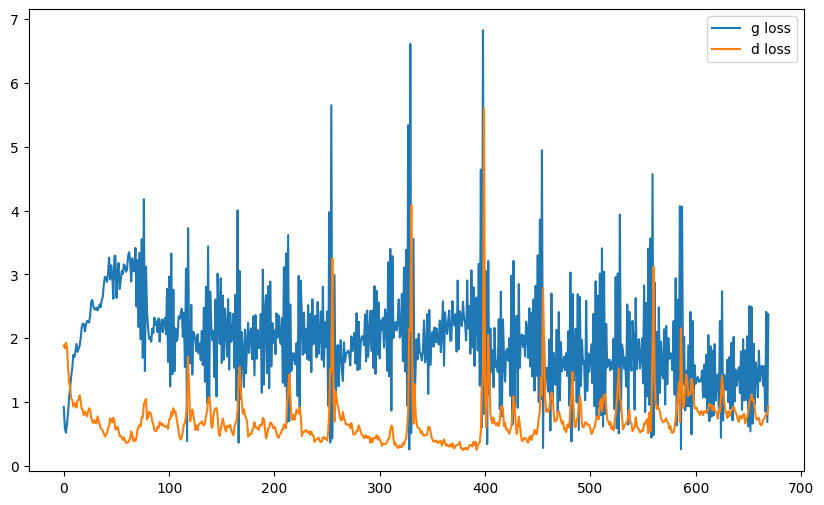

it: 869; g_loss: 3.7210941314697266; d_loss: 1.1735260486602783; avg_real_score: 0.9554809331893921; avg_fake_score: 0.6541401147842407: : 399it [00:28, 14.71it/s] 

generated images


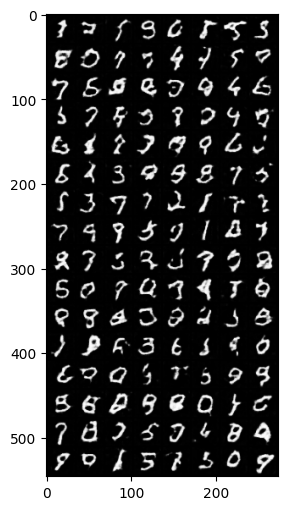

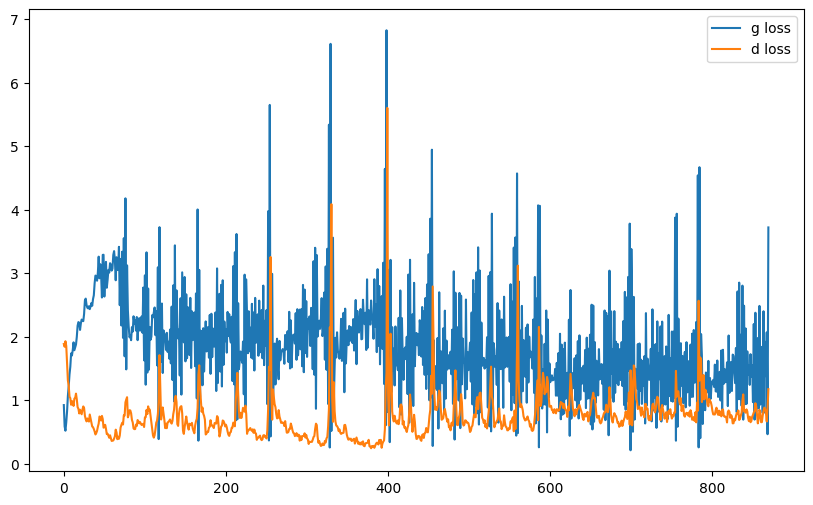

it: 937; g_loss: 0.9628458023071289; d_loss: 1.1929948329925537; avg_real_score: 0.5059161186218262; avg_fake_score: 0.3727332353591919: : 469it [00:33, 13.99it/s]
it: 938; g_loss: 1.3066635131835938; d_loss: 1.0576651096343994; avg_real_score: 0.6711801290512085; avg_fake_score: 0.45691007375717163: : 0it [00:00, ?it/s]

generated images


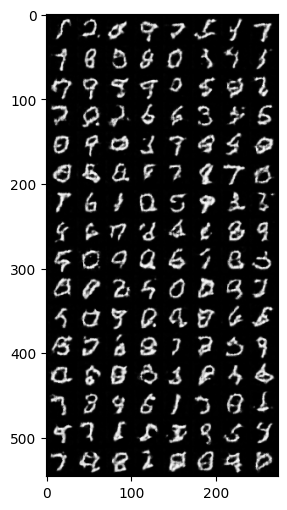

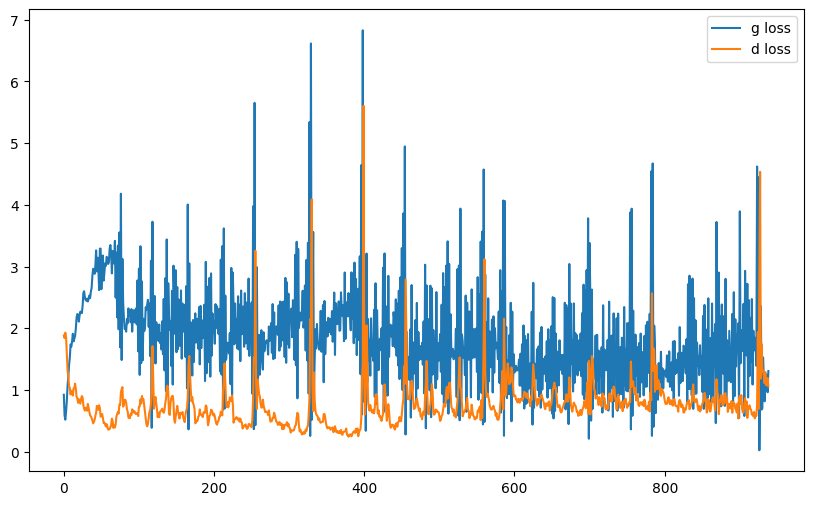

it: 1138; g_loss: 1.8873584270477295; d_loss: 0.8661001920700073; avg_real_score: 0.680419921875; avg_fake_score: 0.3545628786087036: : 199it [00:13, 15.65it/s]    

generated images


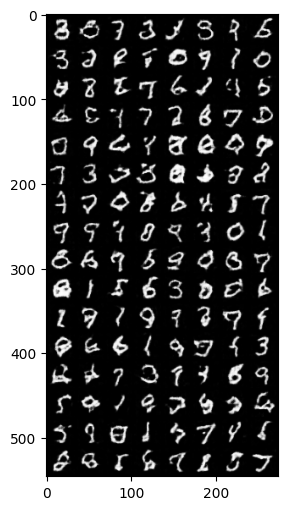

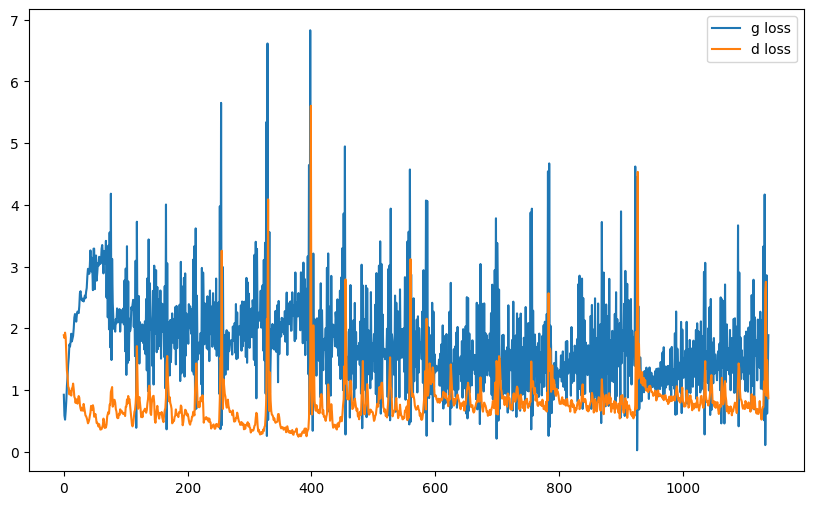

it: 1338; g_loss: 2.0599961280822754; d_loss: 0.6060613393783569; avg_real_score: 0.8078619241714478; avg_fake_score: 0.3048744201660156: : 399it [00:27, 15.13it/s]

generated images


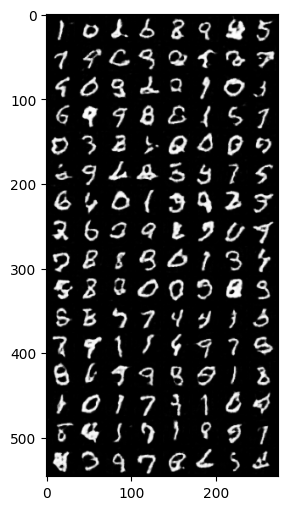

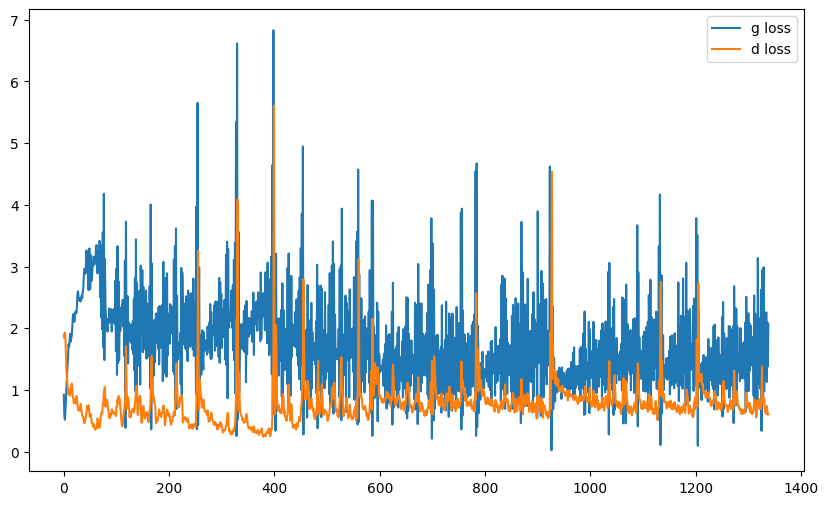

it: 1406; g_loss: 2.100672721862793; d_loss: 0.6793339252471924; avg_real_score: 0.8359508514404297; avg_fake_score: 0.3755640387535095: : 469it [00:32, 14.27it/s]
it: 1407; g_loss: 1.0291016101837158; d_loss: 0.78786301612854; avg_real_score: 0.5816037654876709; avg_fake_score: 0.1842283308506012: : 0it [00:00, ?it/s]

generated images


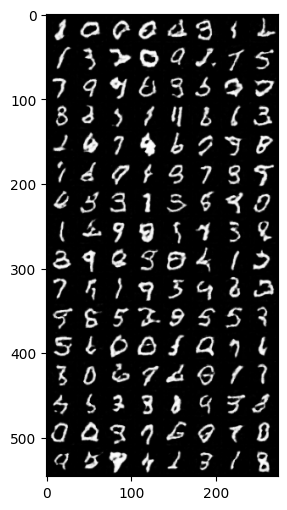

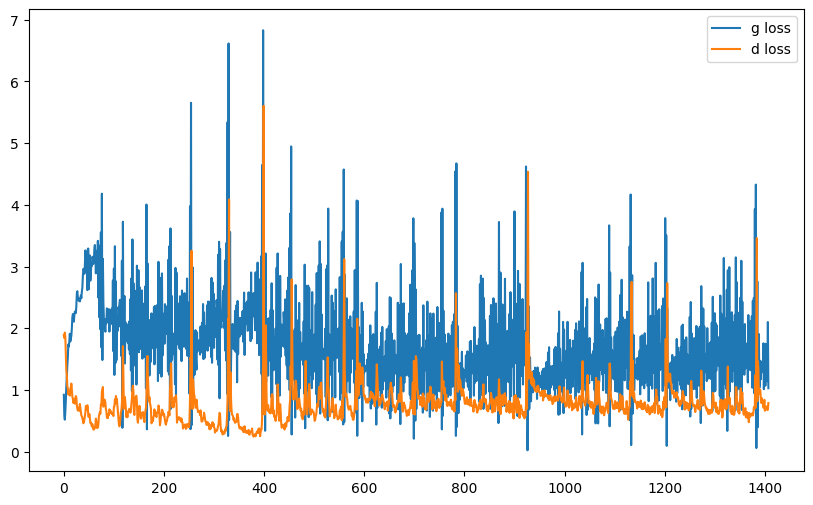

it: 1607; g_loss: 2.3435115814208984; d_loss: 0.8382017612457275; avg_real_score: 0.8209424018859863; avg_fake_score: 0.452303946018219: : 199it [00:14, 15.35it/s]  

generated images


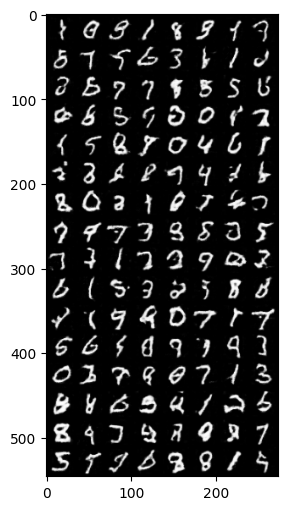

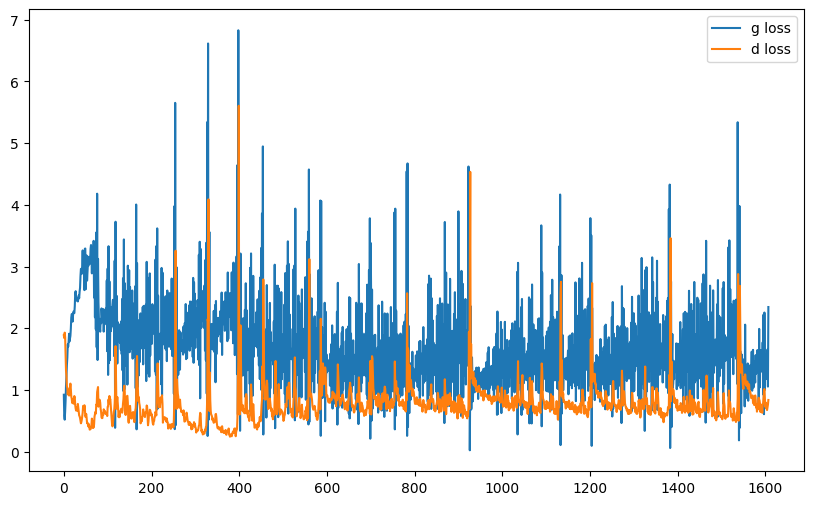

it: 1807; g_loss: 2.4721550941467285; d_loss: 0.65952467918396; avg_real_score: 0.8702182769775391; avg_fake_score: 0.38164305686950684: : 399it [00:28, 15.05it/s]

generated images


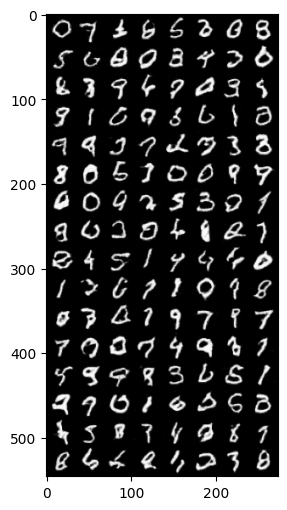

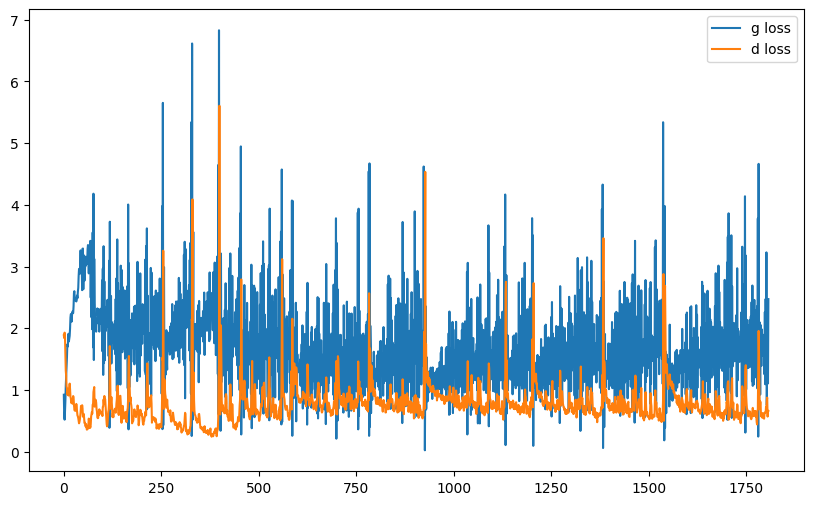

it: 1875; g_loss: 1.6848335266113281; d_loss: 0.6005819439888; avg_real_score: 0.7736920118331909; avg_fake_score: 0.2686014771461487: : 469it [00:34, 13.74it/s]
it: 1876; g_loss: 1.5970748662948608; d_loss: 0.6163680553436279; avg_real_score: 0.7381695508956909; avg_fake_score: 0.24856285750865936: : 0it [00:00, ?it/s]

generated images


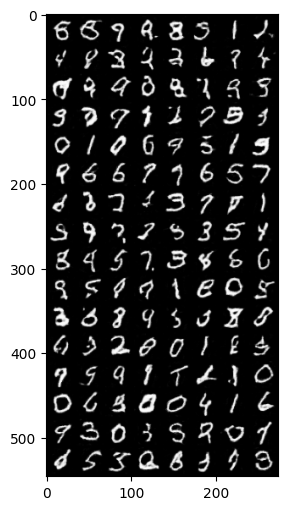

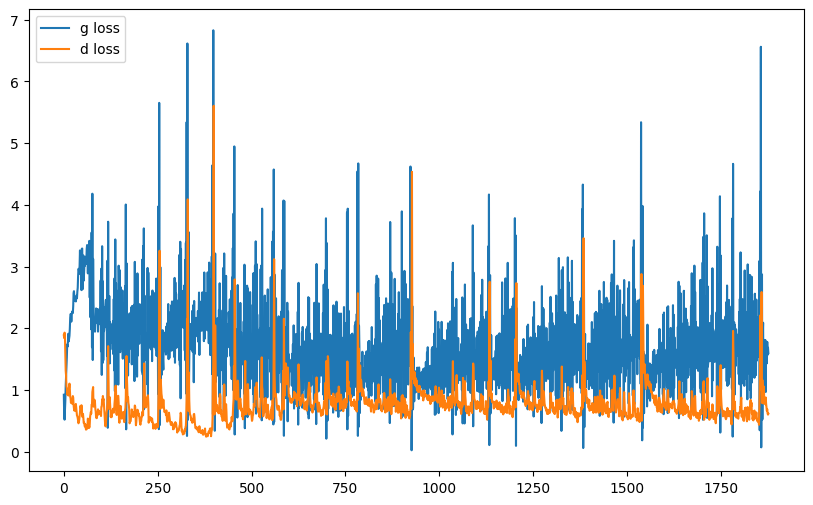

it: 2076; g_loss: 2.470712900161743; d_loss: 0.6076862215995789; avg_real_score: 0.8722624778747559; avg_fake_score: 0.35431188344955444: : 199it [00:14, 12.34it/s]

generated images


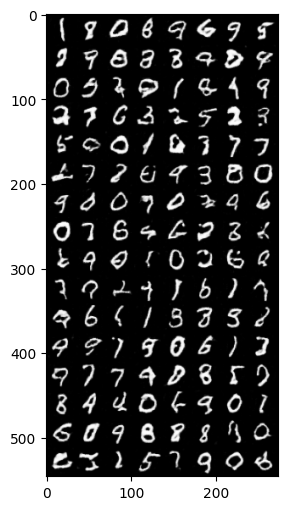

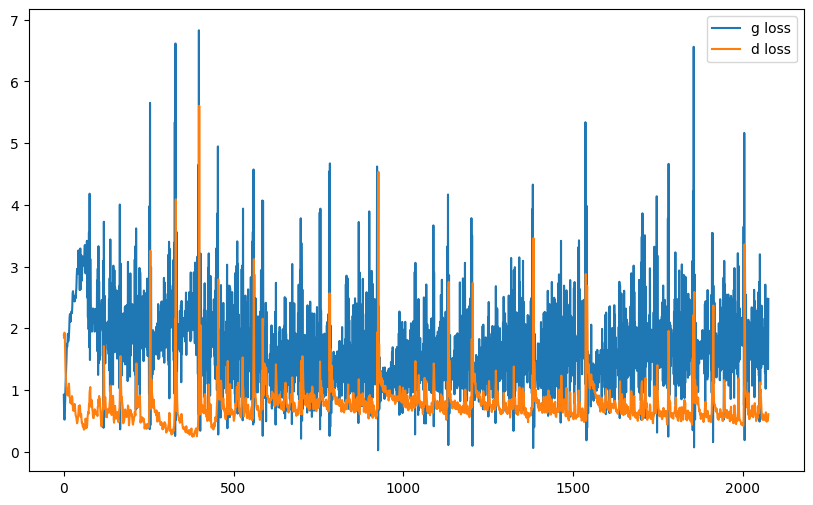

it: 2276; g_loss: 1.8540767431259155; d_loss: 0.46150586009025574; avg_real_score: 0.7958381772041321; avg_fake_score: 0.1918976604938507: : 399it [00:30, 14.04it/s]

generated images


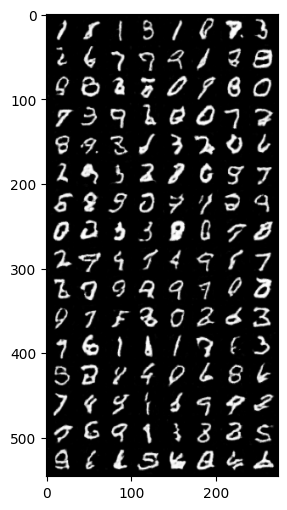

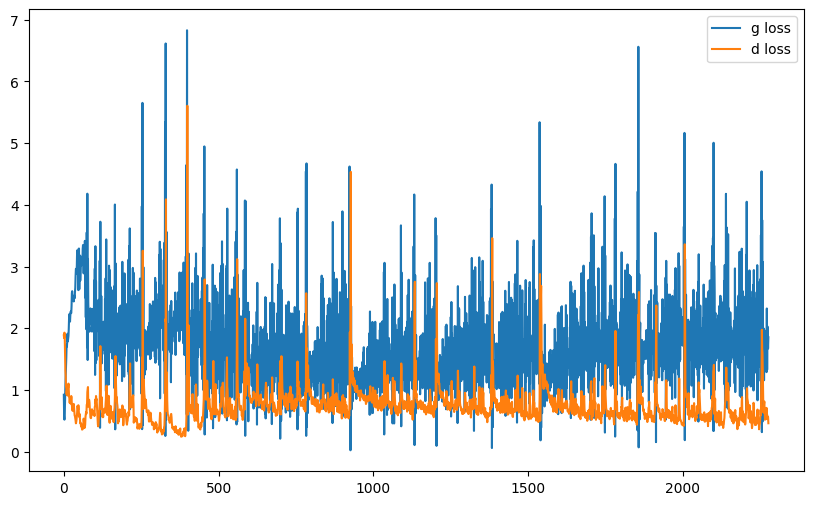

it: 2344; g_loss: 0.4805926978588104; d_loss: 2.328723430633545; avg_real_score: 0.12120208144187927; avg_fake_score: 0.031144410371780396: : 469it [00:35, 13.12it/s]


In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())

        # 真实图像的标签为 1
        real_labels = get_labels_one(cur_batch_size)
        # 假图像的标签为 0
        fake_labels = get_labels_zero(cur_batch_size)


        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, real_labels) + criterion(yhat_fake, fake_labels) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###


        g_loss = criterion(netD(fake_im), real_labels)  #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            #fake_im = G(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [ ]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()

        self.upscaling_z = get_upscaling_block(nz, ngf*8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, 4, 1, 0)

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        self.rest_model = nn.Sequential(
            get_upscaling_block(ngf*16, ngf*4, 4, 2, 1),  # (n_batch, ngf*4, 8, 8)
            get_upscaling_block(ngf*4, ngf, 4, 2, 1),  # (n_batch, ngf*2, 16, 16)
            get_upscaling_block(ngf, nchannels, 4, 2, 1, last_layer=True)  # (n_batch, nchannels, 32, 32)
        )

        ###################

    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        x = self.upscaling_z(x)  # (n_batch, ngf*8, 4, 4)
        y = self.upscaling_c(y)  # (n_batch, ngf*8, 4, 4)

        x = torch.cat([x, y], dim=1)  # (n_batch, ngf**16, 4, 4)

        return self.rest_model(x)


### 4.1.2 Discriminator

In [ ]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False)

        ###################
        #                 #
        # YOUR CODE HERE  #

        self.rest = nn.Sequential(
            get_downscaling_block(ndf*4, ndf*8, 4, 2, 1),  # (n_batch, ndf*8, 8, 8)
            get_downscaling_block(ndf*8, ndf*16, 4, 2, 1),  # (n_batch, ndf*16, 4, 4)
            get_downscaling_block(ndf*16, nchannels, 4, 1, 0, is_last=True)  # (n_batch, 1, 1, 1)
        )


        #                 #
        ###################

    def forward(self, x, y):
        '''
        x: Input image (shape: [batch_size, nchannels, 32, 32])
        y: Class one-hot vector (shape: [batch_size, nc])
        '''
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        y = y.unsqueeze(2).unsqueeze(2)  # (n_batch, nc, 1, 1)
        y = y.repeat(1, 1, x.shape[2], x.shape[3])  # (n_batch, nc, 32, 32)

        x = self.downscale_x(x)  # (n_batch, ndf*2, 16, 16)
        y = self.downscale_y(y)  # (n_batch, ndf*2, 16, 16)

        x = torch.cat([x, y], dim=1)  # (n_batch, ndf*4, 16, 16)

        return self.rest(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 4.1.3 Sanity Checks

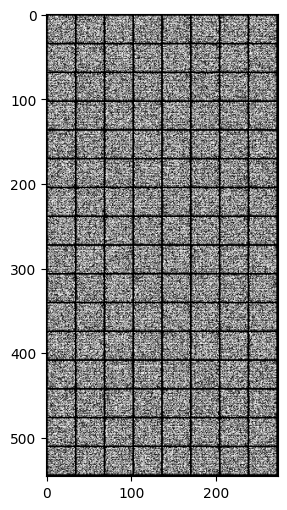

In [ ]:
# CONDITIONAL GENERATOR SANITY CHECKING

# real_labels = torch.randint(0, 10, (batch_size,))
real_batch, real_labels = next(iter(dataloader))

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [ ]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

torch.Size([128, 64, 16, 16])
torch.Size([128, 64, 16, 16])


## 4.2 Training

In [ ]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



it: 0; g_loss: 3.6136629581451416; d_loss: 0.8595350980758667; avg_real_score: 0.8132331371307373; avg_fake_score: 0.3917752504348755: : 0it [00:00, ?it/s]

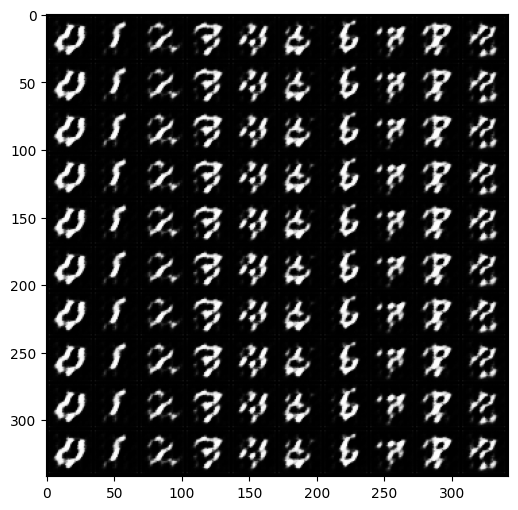

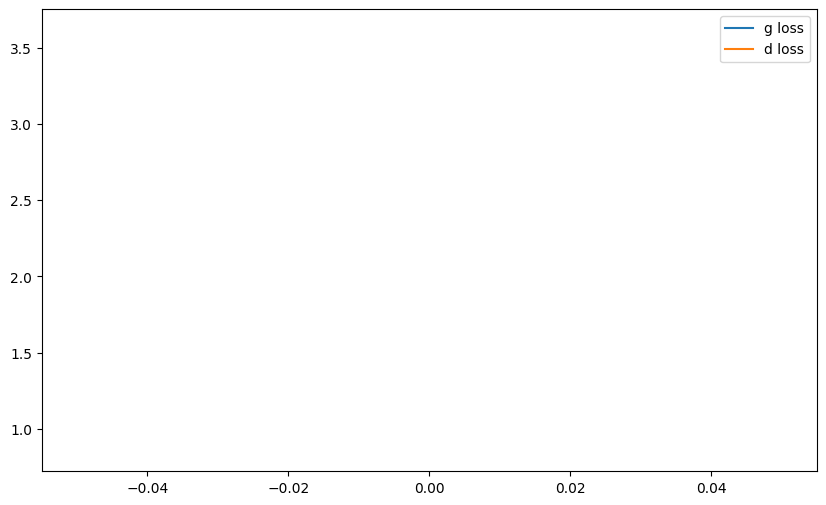

it: 200; g_loss: 2.527517318725586; d_loss: 0.60878586769104; avg_real_score: 0.7794060707092285; avg_fake_score: 0.23128247261047363: : 200it [00:30,  6.83it/s]  

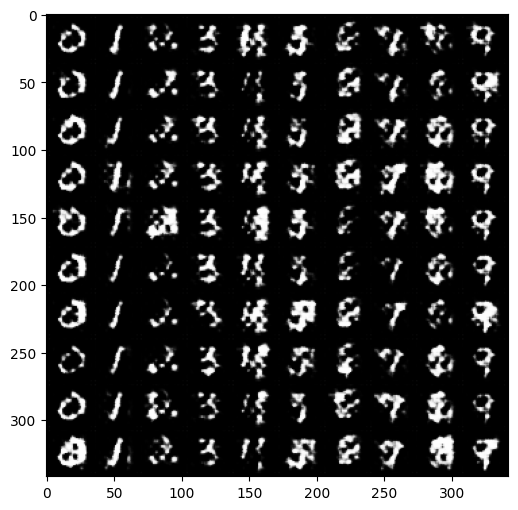

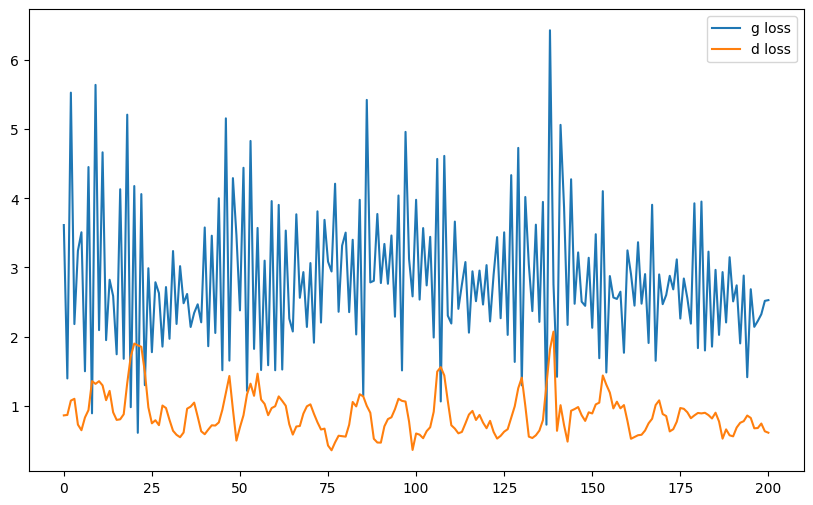

it: 400; g_loss: 2.18695330619812; d_loss: 0.7108290195465088; avg_real_score: 0.7404650449752808; avg_fake_score: 0.27010416984558105: : 400it [01:02,  6.59it/s] 

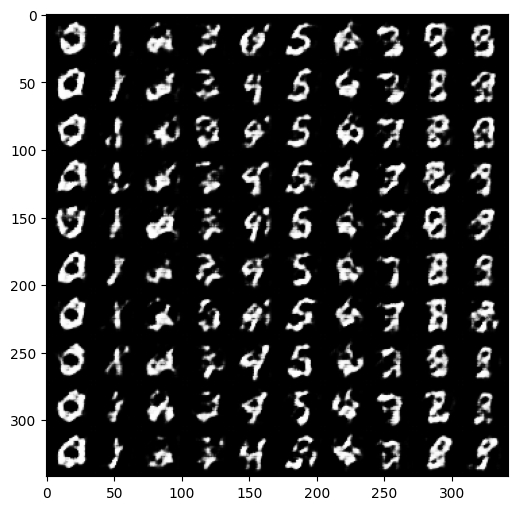

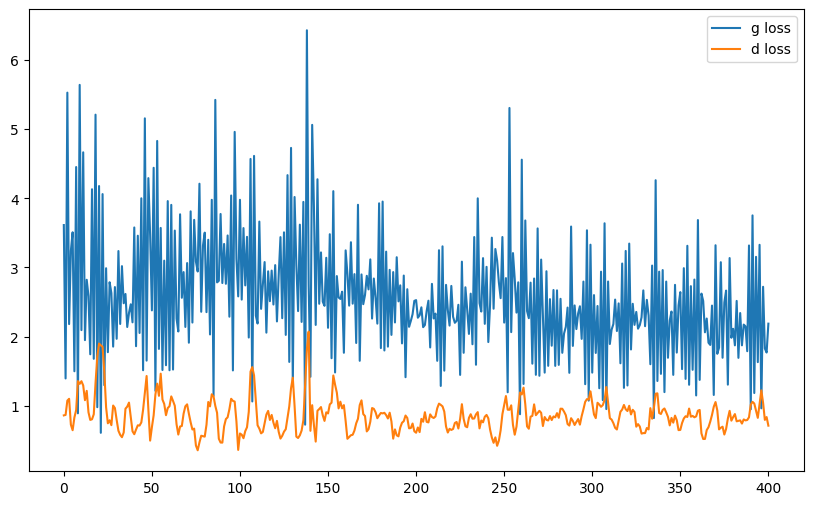

it: 468; g_loss: 3.0400748252868652; d_loss: 0.9668807983398438; avg_real_score: 0.8254585266113281; avg_fake_score: 0.4712525010108948: : 469it [01:13,  6.40it/s]
it: 469; g_loss: 1.486100673675537; d_loss: 0.8896496295928955; avg_real_score: 0.5474307537078857; avg_fake_score: 0.12512549757957458: : 0it [00:00, ?it/s]

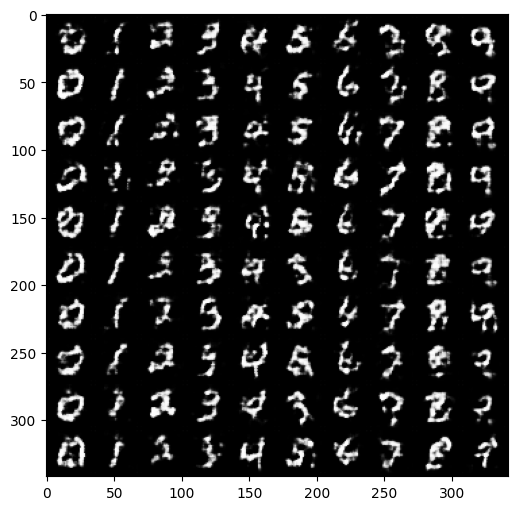

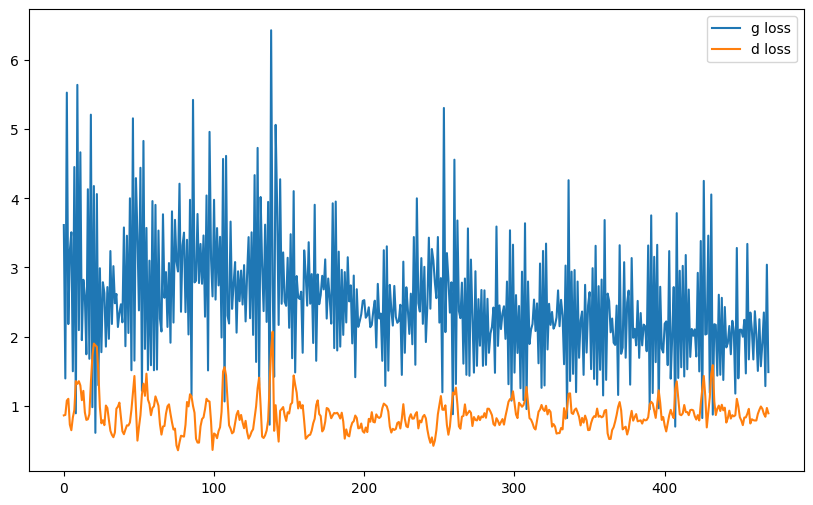

it: 669; g_loss: 1.817204236984253; d_loss: 1.0298309326171875; avg_real_score: 0.7447458505630493; avg_fake_score: 0.44987520575523376: : 200it [00:32,  6.29it/s]

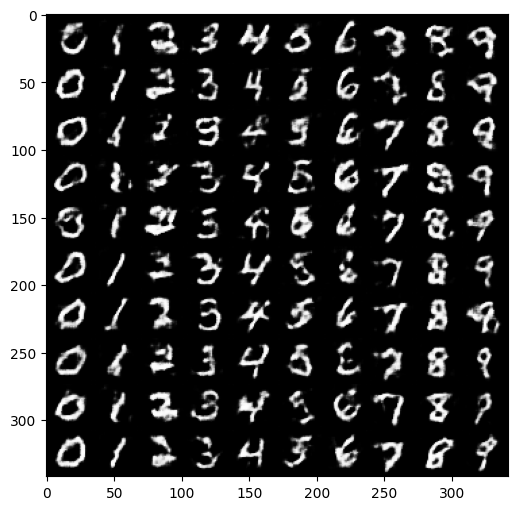

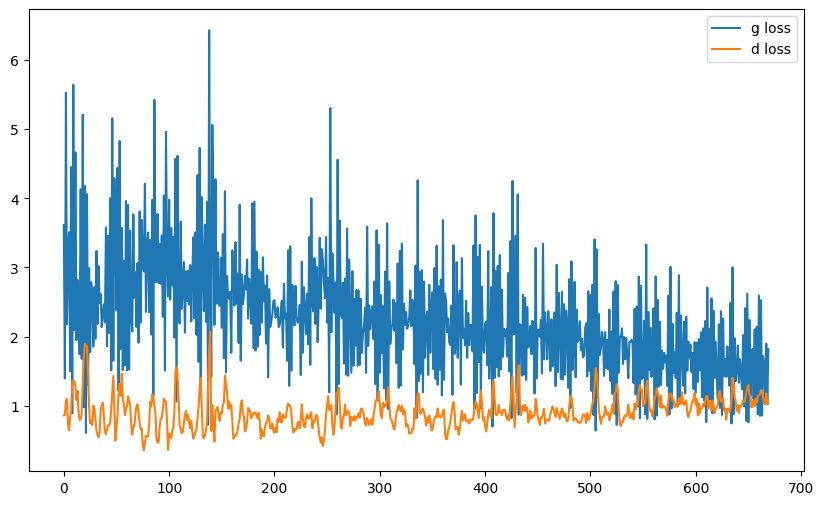

it: 869; g_loss: 0.9708945751190186; d_loss: 1.2350409030914307; avg_real_score: 0.4881351888179779; avg_fake_score: 0.30477285385131836: : 400it [01:05,  6.31it/s]

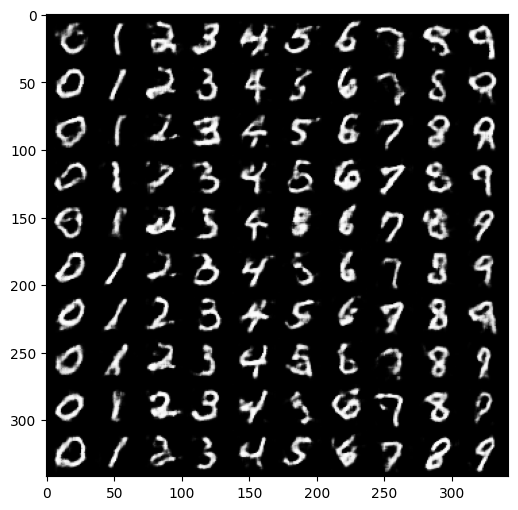

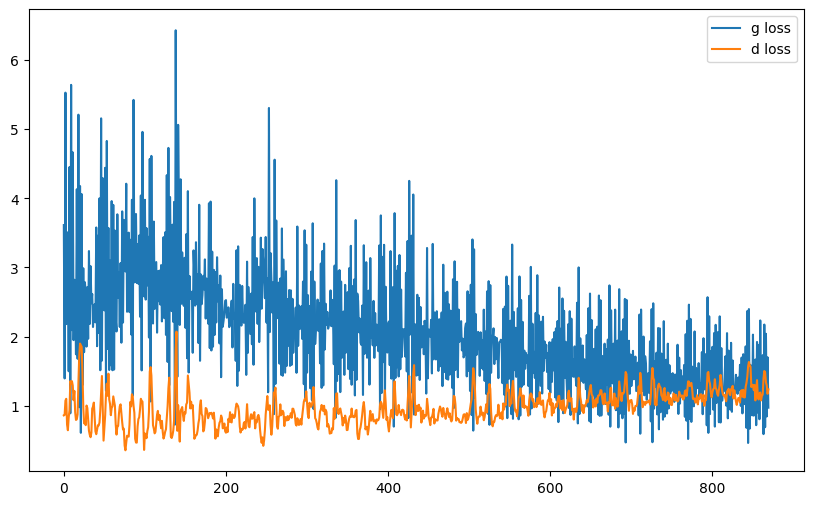

it: 937; g_loss: 2.2631888389587402; d_loss: 1.3891186714172363; avg_real_score: 0.8169188499450684; avg_fake_score: 0.647843599319458: : 469it [01:17,  6.05it/s]
it: 938; g_loss: 0.7814819812774658; d_loss: 1.3390514850616455; avg_real_score: 0.3918383717536926; avg_fake_score: 0.2191539853811264: : 0it [00:00, ?it/s]

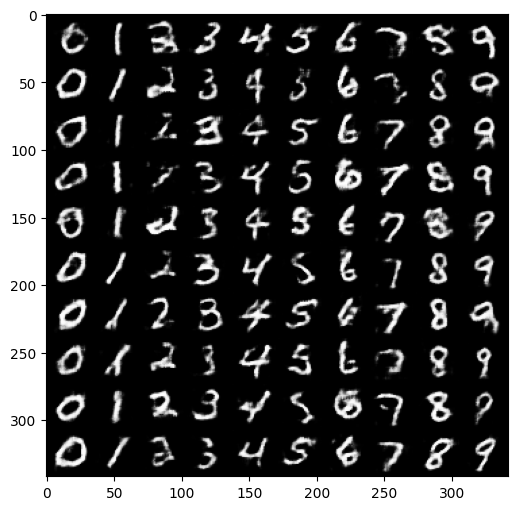

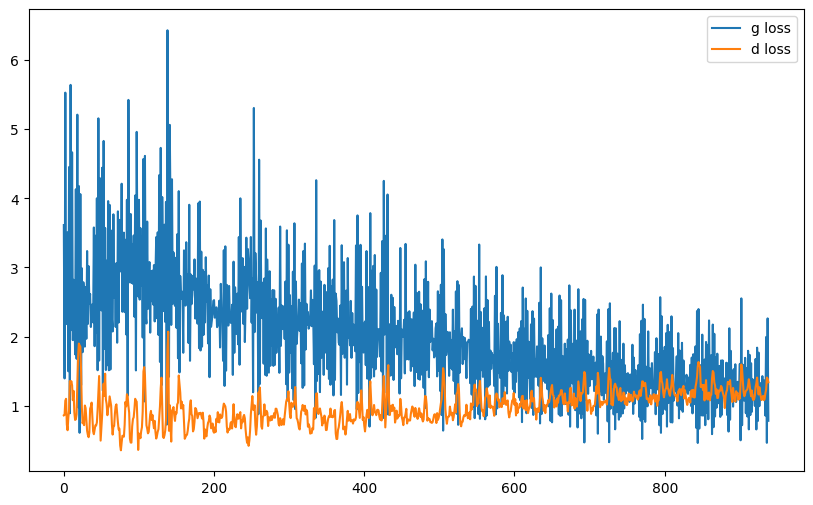

it: 1138; g_loss: 0.8214829564094543; d_loss: 1.207521915435791; avg_real_score: 0.45336294174194336; avg_fake_score: 0.2767975330352783: : 200it [00:32,  6.24it/s]

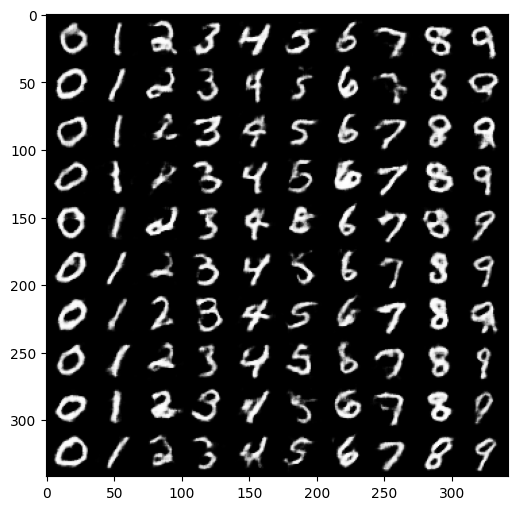

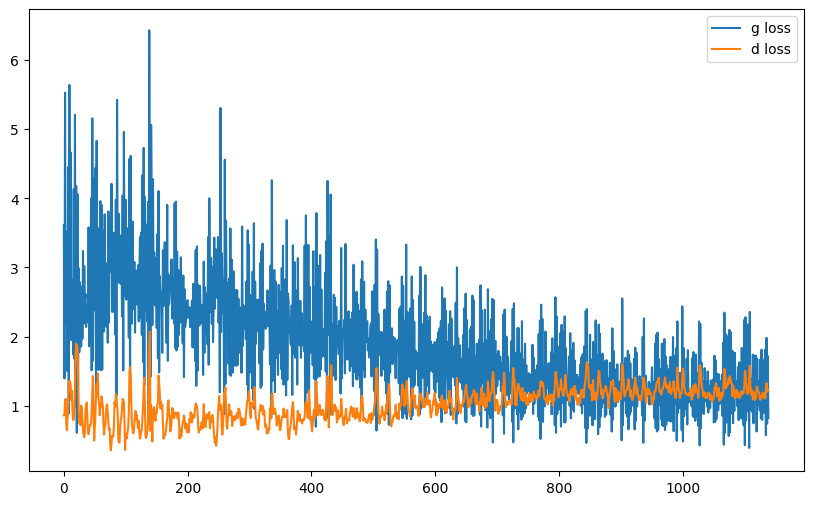

it: 1338; g_loss: 1.1102761030197144; d_loss: 1.2411829233169556; avg_real_score: 0.5345519781112671; avg_fake_score: 0.4002819061279297: : 400it [01:06,  6.28it/s]

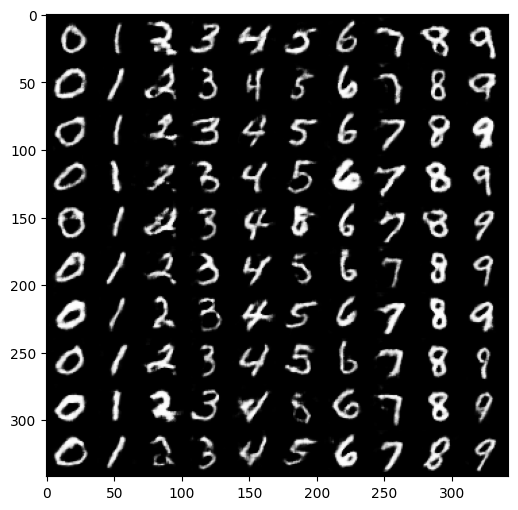

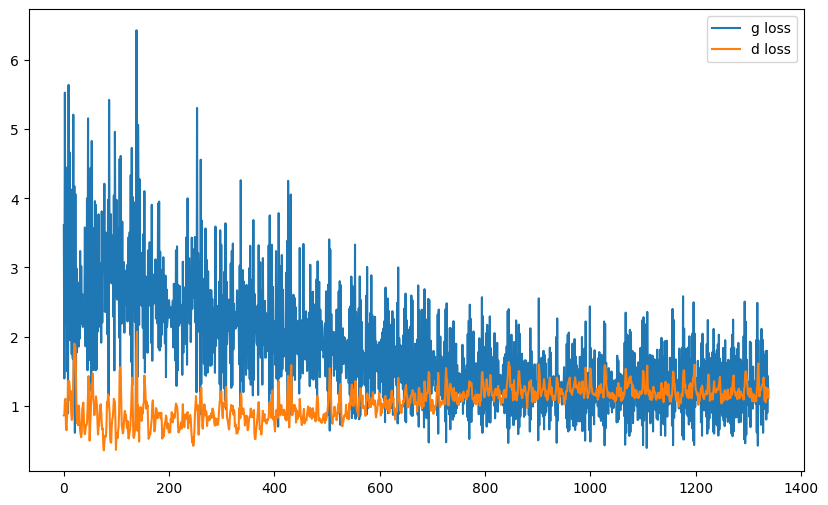

it: 1406; g_loss: 0.9213792085647583; d_loss: 1.4053452014923096; avg_real_score: 0.39022159576416016; avg_fake_score: 0.2555477023124695: : 469it [01:18,  5.98it/s]
it: 1407; g_loss: 1.120732307434082; d_loss: 1.1731817722320557; avg_real_score: 0.6468245983123779; avg_fake_score: 0.4802405834197998: : 0it [00:00, ?it/s]

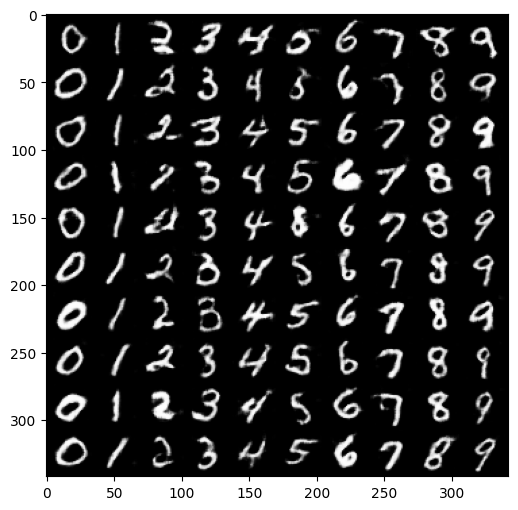

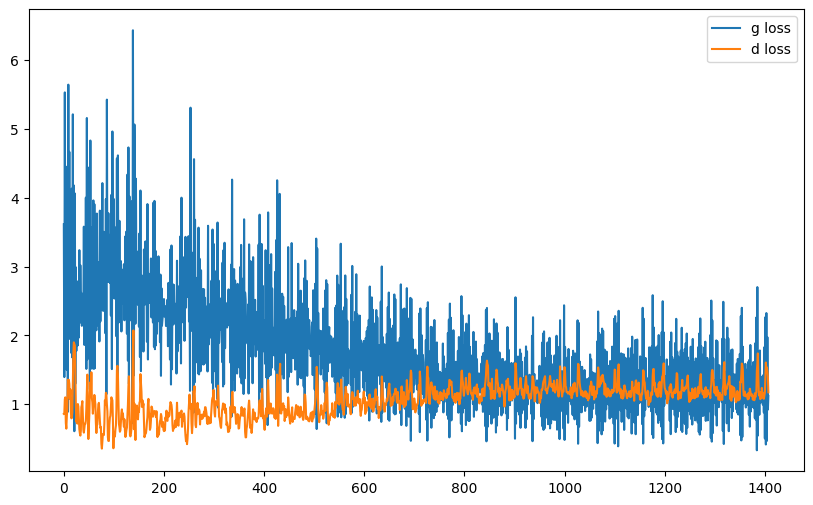

it: 1607; g_loss: 0.7741105556488037; d_loss: 1.132893443107605; avg_real_score: 0.47469252347946167; avg_fake_score: 0.26503658294677734: : 200it [00:33,  6.31it/s]

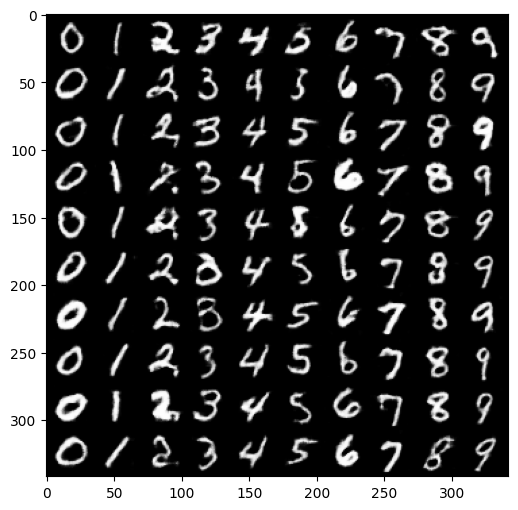

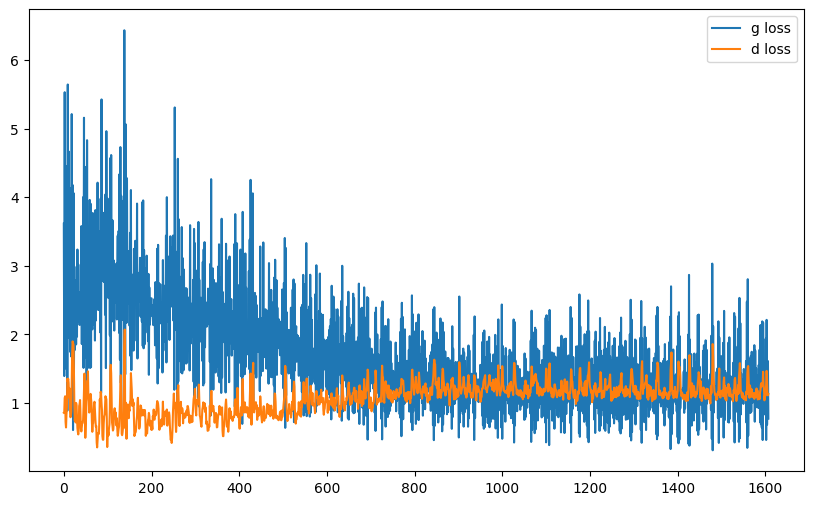

it: 1807; g_loss: 1.470839262008667; d_loss: 1.1928110122680664; avg_real_score: 0.68113774061203; avg_fake_score: 0.5141789317131042: : 400it [01:06,  5.63it/s]  

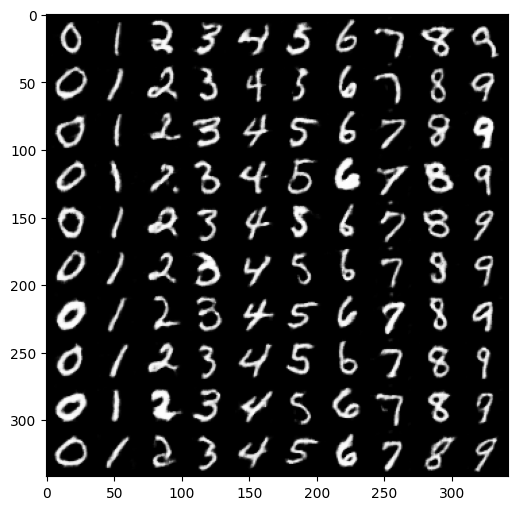

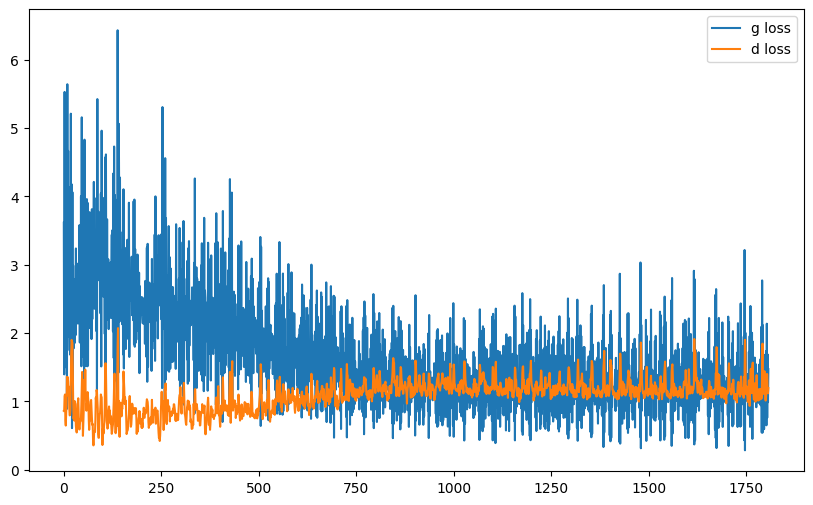

it: 1875; g_loss: 0.7261978983879089; d_loss: 1.5841485261917114; avg_real_score: 0.2903953492641449; avg_fake_score: 0.18323878943920135: : 469it [01:18,  5.98it/s]
it: 1876; g_loss: 1.2556531429290771; d_loss: 1.3130813837051392; avg_real_score: 0.6982307434082031; avg_fake_score: 0.5736749172210693: : 0it [00:00, ?it/s]

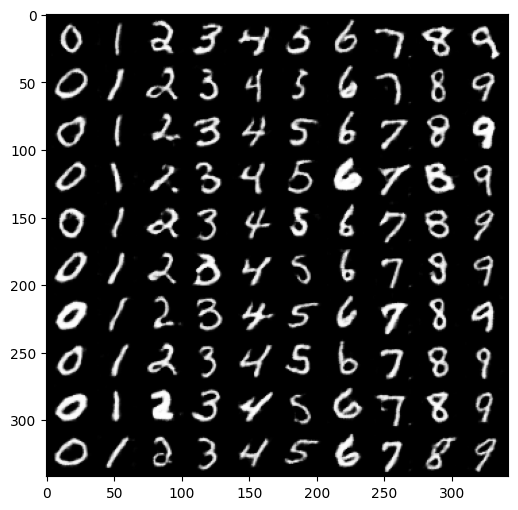

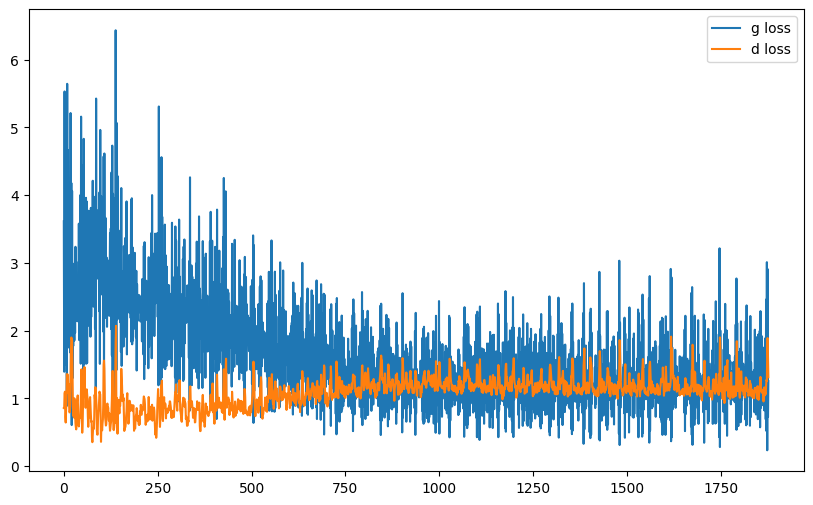

it: 2076; g_loss: 2.417990207672119; d_loss: 1.1390324831008911; avg_real_score: 0.8038229942321777; avg_fake_score: 0.5687884092330933: : 200it [00:33,  6.22it/s]  

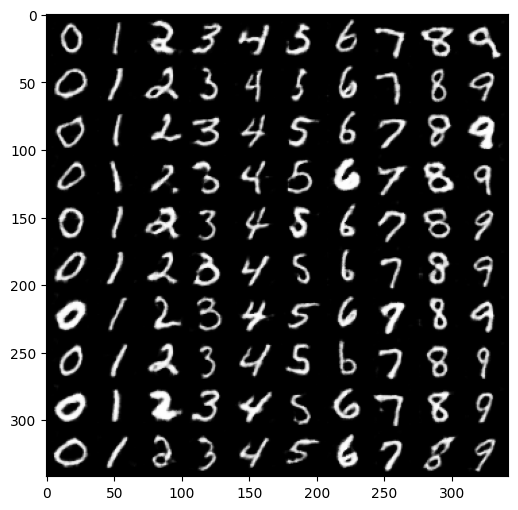

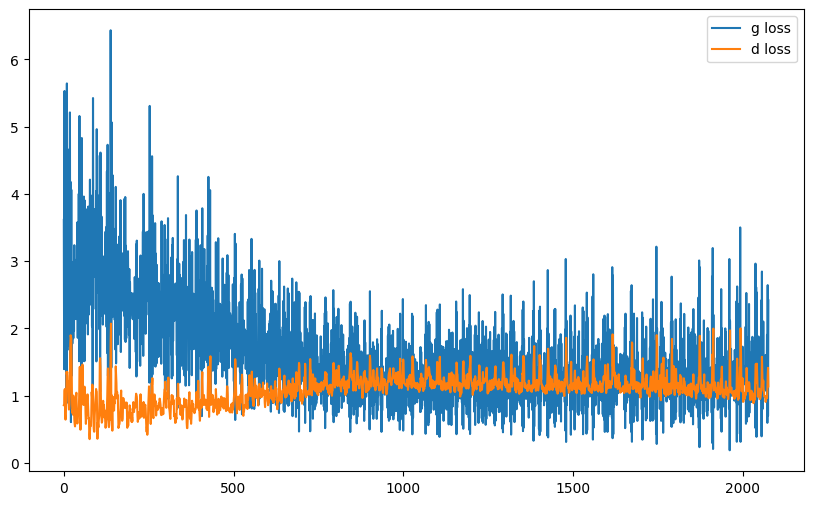

it: 2276; g_loss: 3.2781662940979004; d_loss: 1.0717270374298096; avg_real_score: 0.9028433561325073; avg_fake_score: 0.5901824235916138: : 400it [01:07,  6.22it/s] 

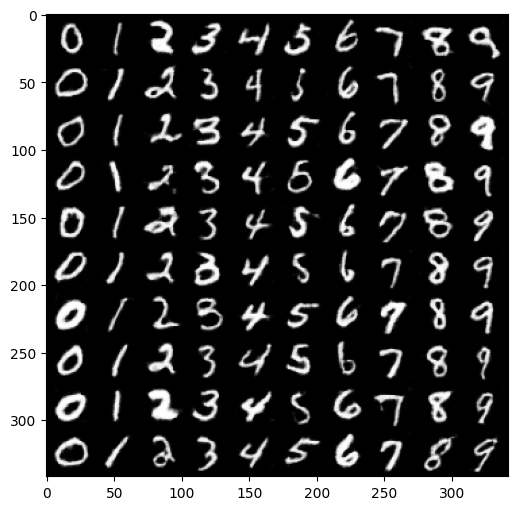

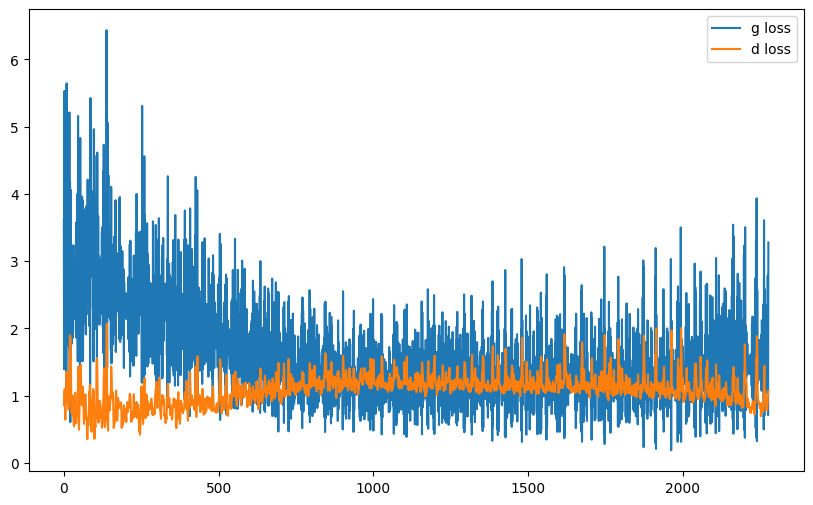

it: 2344; g_loss: 1.5714467763900757; d_loss: 0.7219619154930115; avg_real_score: 0.6124119162559509; avg_fake_score: 0.17055949568748474: : 469it [01:18,  5.94it/s]


In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing


for epoch in range(nb_epochs):

    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch
        im = im.to(device)


        y = F.one_hot(labels).float().to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z, y)

        # 3. Classify real image with D
        yhat_real = netD(im, y)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach(), y)

        # 真实图像的标签为 1
        real_labels = get_labels_one(cur_batch_size)
        # 假图像的标签为 0
        fake_labels = get_labels_zero(cur_batch_size)


        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, real_labels) + criterion(yhat_fake, fake_labels)# YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###


        g_loss = criterion(netD(fake_im, y), real_labels)# YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")

        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)

            plt.imshow(pil_grid)
            plt.show()


            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1


## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

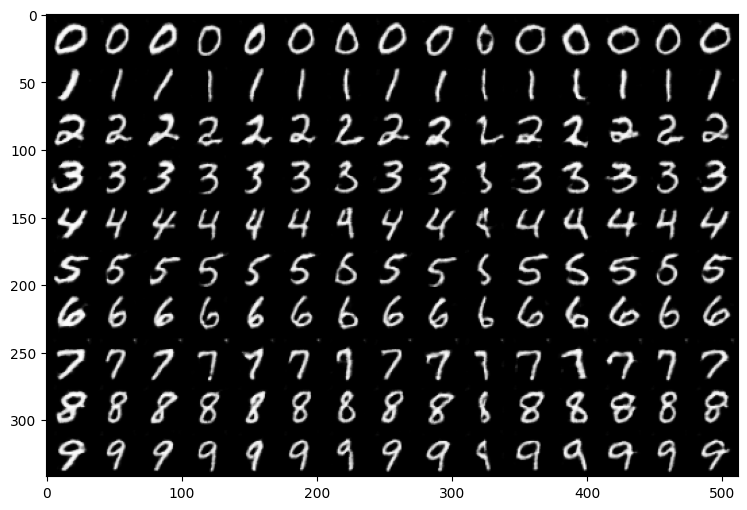

In [ ]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)

plt.imshow(pil_grid)
plt.show()
